In [1]:
!pip install kagglehub

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import kagglehub

In [2]:
print("Downloading dataset...")
path = kagglehub.dataset_download("killa92/cardiac-semantic-segmentation-dataset")
print(f"Dataset downloaded to: {path}")

# Explore dataset structure
for root, dirs, files in os.walk(path):
    level = root.replace(path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Show first 5 files only
        print(f'{subindent}{file}')
    if len(files) > 5:
        print(f'{subindent}... and {len(files)-5} more files')

100%|██████████| 217M/217M [00:01<00:00, 153MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/killa92/cardiac-semantic-segmentation-dataset/versions/1
1/
  cardiac/
    images/
      505.png
      284.png
      424.png
      1485.png
      415.png
      ... and 1712 more files
    labels/
      505.png
      284.png
      424.png
      1485.png
      415.png
      ... and 1712 more files


In [3]:
class CardiacDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform

        # Find images and masks folders
        self.images_path = None
        self.masks_path = None

        for root, dirs, files in os.walk(data_path):
            if 'image' in root.lower() or 'img' in root.lower():
                if files:  # Check if folder has files
                    self.images_path = root
            elif 'mask' in root.lower() or 'label' in root.lower() or 'gt' in root.lower():
                if files:  # Check if folder has files
                    self.masks_path = root

        # If not found, look for train/test structure
        if self.images_path is None:
            for root, dirs, files in os.walk(data_path):
                if files and any(f.lower().endswith(('.jpg', '.jpeg', '.png', '.tif', '.tiff')) for f in files):
                    # Check if this looks like images (not masks)
                    sample_file = next(f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tif', '.tiff')))
                    sample_path = os.path.join(root, sample_file)
                    img = Image.open(sample_path)
                    img_array = np.array(img)

                    # Assume it's images if it's RGB or grayscale with reasonable values
                    if len(img_array.shape) == 3 or (len(img_array.shape) == 2 and img_array.max() > 10):
                        if self.images_path is None:
                            self.images_path = root
                        elif self.masks_path is None and root != self.images_path:
                            self.masks_path = root

        print(f"Images path: {self.images_path}")
        print(f"Masks path: {self.masks_path}")

        if self.images_path is None:
            raise ValueError("Could not find images folder")

        # Get all image files
        self.image_files = []
        for file in os.listdir(self.images_path):
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.tif', '.tiff')):
                self.image_files.append(file)

        self.image_files.sort()
        print(f"Found {len(self.image_files)} images")

        # Get corresponding mask files if masks folder exists
        self.mask_files = []
        if self.masks_path:
            for img_file in self.image_files:
                # Try different mask naming conventions
                base_name = os.path.splitext(img_file)[0]
                mask_candidates = [
                    img_file,  # Same name
                    base_name + '_mask.png',
                    base_name + '_gt.png',
                    base_name + '.png',
                    base_name + '.jpg',
                    base_name + '_label.png'
                ]

                mask_file = None
                for candidate in mask_candidates:
                    if os.path.exists(os.path.join(self.masks_path, candidate)):
                        mask_file = candidate
                        break

                self.mask_files.append(mask_file)

            valid_pairs = sum(1 for mask in self.mask_files if mask is not None)
            print(f"Found {valid_pairs} valid image-mask pairs")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.images_path, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')

        # Load mask if available
        if self.masks_path and self.mask_files[idx]:
            mask_path = os.path.join(self.masks_path, self.mask_files[idx])
            mask = Image.open(mask_path).convert('L')  # Convert to grayscale
        else:
            # Create dummy mask for demo purposes
            mask = Image.new('L', image.size, 0)

        # Apply transforms
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # Convert mask to binary (0 or 1)
        mask = (mask > 0.5).float()

        return image, mask

In [17]:
class MultiHeadAttention(nn.Module):
    def __init__(self, dim, num_heads=8, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.dim = dim
        self.head_dim = dim // num_heads

        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads=8, mlp_ratio=4, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MultiHeadAttention(dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(dim)

        mlp_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class CNNEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN encoder with skip connections
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.conv2 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.conv3 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.conv4 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Return skip connections for decoder
        x1 = self.conv1(x)      # 128x128x64
        x2 = self.conv2(x1)     # 64x64x128
        x3 = self.conv3(x2)     # 32x32x256
        x4 = self.conv4(x3)     # 16x16x512

        return [x1, x2, x3, x4]

class CNNDecoder(nn.Module):
    def __init__(self, embed_dim=512):
        super().__init__()
        # Project transformer output back to CNN feature space
        self.proj = nn.Linear(embed_dim, 512)

        self.up4 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),  # 256 + 256 from skip
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),  # 128 + 128 from skip
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),   # 64 + 64 from skip
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.final = nn.Conv2d(64, 1, 1)  # Output single channel mask

    def forward(self, transformer_out, skip_connections):
        # transformer_out shape: (B, 256, embed_dim)
        B = transformer_out.shape[0]

        # Project and reshape to feature map
        x = self.proj(transformer_out)  # (B, 256, 512)
        x = x.transpose(1, 2).reshape(B, 512, 16, 16)  # Reshape to 16x16 feature map

        # Decoder with skip connections
        x = self.up4(x)  # 32x32x256
        x = torch.cat([x, skip_connections[2]], dim=1)  # Concatenate with skip connection
        x = self.conv4(x)

        x = self.up3(x)  # 64x64x128
        x = torch.cat([x, skip_connections[1]], dim=1)
        x = self.conv3(x)

        x = self.up2(x)  # 128x128x64
        x = torch.cat([x, skip_connections[0]], dim=1)
        x = self.conv2(x)

        x = self.final(x)  # 128x128x1

        return torch.sigmoid(x)

class TransUNet(nn.Module):
    def __init__(self, img_size=128, patch_size=16, embed_dim=512, num_heads=8, num_layers=6):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size

        # CNN Encoder reduces 128x128 to 16x16, so we have 16x16 patches
        self.feature_size = 16  # After 3 MaxPool2d operations: 128 -> 64 -> 32 -> 16
        self.num_patches = self.feature_size * self.feature_size  # 16*16 = 256

        # CNN Encoder
        self.cnn_encoder = CNNEncoder()

        # Patch embedding for transformer
        # After CNN encoding, we have 16x16x512 feature map
        self.patch_embed = nn.Conv2d(512, embed_dim, kernel_size=1)
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches, embed_dim))

        # Transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads) for _ in range(num_layers)
        ])

        # CNN Decoder
        self.cnn_decoder = CNNDecoder(embed_dim)

        # Initialize position embeddings
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

    def forward(self, x):
        # CNN Encoding with skip connections
        skip_connections = self.cnn_encoder(x)  # [64, 128, 256, 512] channels

        # Take the deepest feature map for transformer
        cnn_features = skip_connections[-1]  # Should be 16x16x512

        # Patch embedding
        patches = self.patch_embed(cnn_features)  # 16x16x512 -> 16x16xembed_dim
        B, C, H, W = patches.shape
        patches = patches.flatten(2).transpose(1, 2)  # (B, H*W, embed_dim) = (B, 256, embed_dim)

        # Debug print to check dimensions
        # print(f"Patches shape: {patches.shape}, pos_embed shape: {self.pos_embed.shape}")

        # Add position embeddings
        patches = patches + self.pos_embed

        # Apply transformer blocks
        for block in self.transformer_blocks:
            patches = block(patches)

        # CNN Decoding
        output = self.cnn_decoder(patches, skip_connections[:-1])  # Exclude the last skip connection

        return output


In [18]:
# 5. DICE LOSS FUNCTION
# ================================

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = pred.contiguous()
        target = target.contiguous()

        intersection = (pred * target).sum(dim=2).sum(dim=2)
        union = pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2)

        dice = (2. * intersection + self.smooth) / (union + self.smooth)

        return 1 - dice.mean()



In [19]:
# ================================
# 6. DATA PREPARATION
# ================================

# Define transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Create dataset
print("Creating dataset...")
dataset = CardiacDataset(path, transform=transform)

# Split dataset (80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create data loaders
batch_size = 4  # Small batch size for CPU
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")


Creating dataset...
Images path: /root/.cache/kagglehub/datasets/killa92/cardiac-semantic-segmentation-dataset/versions/1/cardiac/images
Masks path: /root/.cache/kagglehub/datasets/killa92/cardiac-semantic-segmentation-dataset/versions/1/cardiac/labels
Found 1717 images
Found 1717 valid image-mask pairs
Train dataset size: 1373
Validation dataset size: 344


In [20]:
model = TransUNet(img_size=128, patch_size=16, embed_dim=256, num_heads=8, num_layers=4)
print(f"Model initialized with {sum(p.numel() for p in model.parameters()):,} parameters")

# Loss and optimizer
criterion = DiceLoss()
bce_loss = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)


Model initialized with 11,191,361 parameters


In [21]:
 #8. TRAINING LOOP
# ================================

def train_epoch(model, train_loader, criterion, bce_loss, optimizer):
    model.train()
    total_loss = 0
    num_batches = 0

    for batch_idx, (images, masks) in enumerate(train_loader):
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Calculate combined loss
        dice_loss = criterion(outputs, masks)
        bce_loss_val = bce_loss(outputs, masks)
        loss = dice_loss + bce_loss_val

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

        if batch_idx % 10 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

    return total_loss / num_batches

def validate(model, val_loader, criterion, bce_loss):
    model.eval()
    total_loss = 0
    num_batches = 0

    with torch.no_grad():
        for images, masks in val_loader:
            outputs = model(images)
            dice_loss = criterion(outputs, masks)
            bce_loss_val = bce_loss(outputs, masks)
            loss = dice_loss + bce_loss_val

            total_loss += loss.item()
            num_batches += 1

    return total_loss / num_batches

# Training
print("Starting training...")
num_epochs = 3  # Limited epochs for CPU training

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 30)

    # Train
    train_loss = train_epoch(model, train_loader, criterion, bce_loss, optimizer)
    train_losses.append(train_loss)

    # Validate
    val_loss = validate(model, val_loader, criterion, bce_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


Starting training...

Epoch 1/3
------------------------------
Batch 0/344, Loss: 1.3790
Batch 10/344, Loss: 1.1012
Batch 20/344, Loss: 0.9112
Batch 30/344, Loss: 0.8013
Batch 40/344, Loss: 0.8295
Batch 50/344, Loss: 0.8472
Batch 60/344, Loss: 0.6802
Batch 70/344, Loss: 0.6049
Batch 80/344, Loss: 0.7358
Batch 90/344, Loss: 0.6407
Batch 100/344, Loss: 0.7797
Batch 110/344, Loss: 0.5600
Batch 120/344, Loss: 0.5436
Batch 130/344, Loss: 0.5431
Batch 140/344, Loss: 0.6798
Batch 150/344, Loss: 0.5115
Batch 160/344, Loss: 0.7601
Batch 170/344, Loss: 0.6644
Batch 180/344, Loss: 0.6035
Batch 190/344, Loss: 0.4979
Batch 200/344, Loss: 0.6035
Batch 210/344, Loss: 0.5904
Batch 220/344, Loss: 0.5045
Batch 230/344, Loss: 0.4959
Batch 240/344, Loss: 0.5056
Batch 250/344, Loss: 0.4460
Batch 260/344, Loss: 0.4516
Batch 270/344, Loss: 0.4450
Batch 280/344, Loss: 0.5125
Batch 290/344, Loss: 0.4284
Batch 300/344, Loss: 0.5451
Batch 310/344, Loss: 0.4328
Batch 320/344, Loss: 0.4963
Batch 330/344, Loss: 0.4

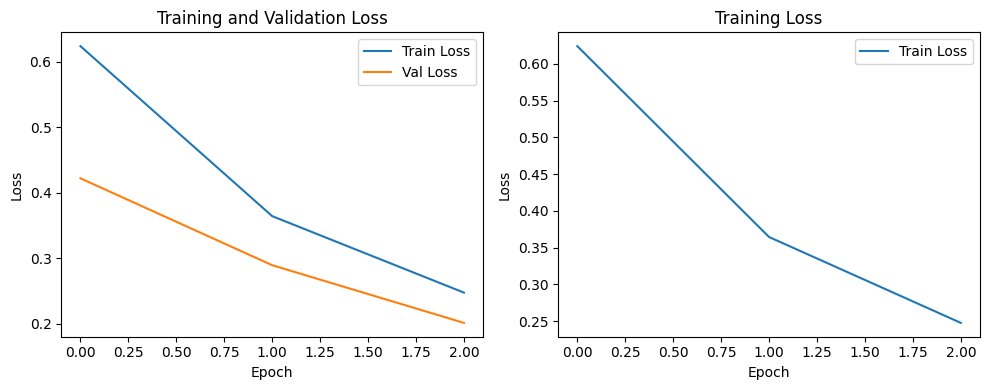

Generating predictions...


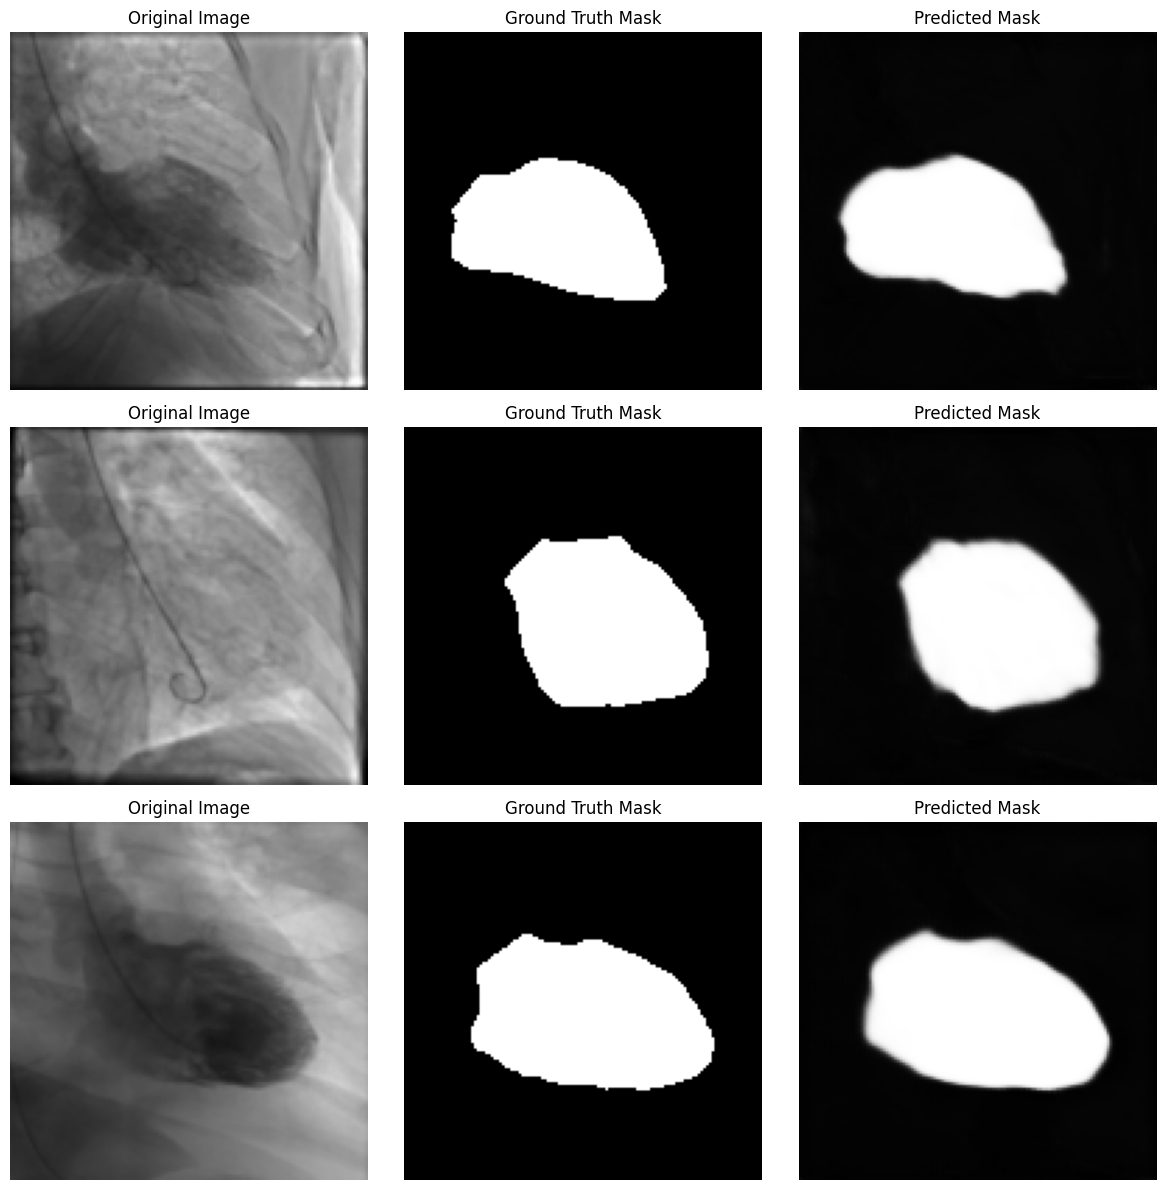

Training completed!
Final training loss: 0.2477
Final validation loss: 0.2015
Model saved as 'transunet_cardiac_segmentation.pth'


In [22]:
# 9. VISUALIZATION
# ================================

def visualize_predictions(model, val_loader, num_samples=3):
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))

    with torch.no_grad():
        for i, (images, masks) in enumerate(val_loader):
            if i >= num_samples:
                break

            # Get predictions
            outputs = model(images)

            # Take first image from batch
            image = images[0].permute(1, 2, 0).numpy()
            mask = masks[0].squeeze().numpy()
            pred = outputs[0].squeeze().numpy()

            # Plot
            axes[i, 0].imshow(image)
            axes[i, 0].set_title('Original Image')
            axes[i, 0].axis('off')

            axes[i, 1].imshow(mask, cmap='gray')
            axes[i, 1].set_title('Ground Truth Mask')
            axes[i, 1].axis('off')

            axes[i, 2].imshow(pred, cmap='gray')
            axes[i, 2].set_title('Predicted Mask')
            axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Plot training curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Visualize predictions
print("Generating predictions...")
visualize_predictions(model, val_loader, num_samples=3)

print("Training completed!")
print(f"Final training loss: {train_losses[-1]:.4f}")
print(f"Final validation loss: {val_losses[-1]:.4f}")

# Save model
torch.save(model.state_dict(), 'transunet_cardiac_segmentation.pth')
print("Model saved as 'transunet_cardiac_segmentation.pth'")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Create a DataFrame with the data from your comparison table
data = {
    'Framework': ['R50-U-Net', 'R50-AttnUNet', 'ViT-CUP', 'R50-ViT-CUP', 'TransUNet'],
    'RV': [87.10, 87.58, 81.46, 86.07, 88.86],
    'Myo': [80.63, 79.20, 70.71, 81.88, 84.53],
    'LV': [94.92, 93.47, 92.18, 94.75, 95.73]
}

df = pd.DataFrame(data)

# 2. Melt the DataFrame to long format for easier plotting with seaborn
df_melted = df.melt(id_vars=['Framework'], value_vars=['RV', 'Myo', 'LV'], var_name='Cardiac Structure', value_name='Dice Score')

# 3. Create the grouped bar chart using seaborn
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
barplot = sns.barplot(x='Framework', y='Dice Score', hue='Cardiac Structure', data=df_melted, palette='viridis')

# 4. Customize the plot to match the style of the image
plt.title('Comparison of Cardiac Segmentation Models by Dice Score', fontsize=16, fontweight='bold')
plt.xlabel('Framework', fontsize=12)
plt.ylabel('Dice Score (%)', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
plt.ylim(0, 100) # Set y-axis limit to 100%
plt.legend(title='Cardiac Structure', loc='upper left')

# 5. Save the plot to a file
plt.tight_layout()
plt.savefig('cardiac_segmentation_comparison.png', dpi=300)
plt.show()

print("Graph generated and saved as 'cardiac_segmentation_comparison.png'")